In [196]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dmgp.layers.activation import TMK, AMK
from dmgp.layers.linear import LinearFlipout

In [197]:
from scipy.spatial.distance import cdist

def squared_exponential_kernel(x1, x2, length_scale=1.0, sigma_f=1.0):
    """Compute the Squared Exponential (RBF) kernel between two sets of inputs."""
    sqdist = cdist(x1, x2, 'sqeuclidean')
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# Training data is 200 points in [-7,7] inclusive regularly spaced
num_samples = 200  # Number of samples to generate
length_scale = 1.0  # Length scale of the SE kernel
sigma_f = 1.0  # Signal variance

# Generate input points and compute the covariance matrix using SE kernel
train_x = np.linspace(-7, 7, num_samples).reshape(-1, 1)
train_x_cov = squared_exponential_kernel(train_x, train_x, length_scale, sigma_f)
# Generate zero-mean Gaussian data with the computed covariance matrix
train_y = np.random.multivariate_normal(np.zeros(num_samples), train_x_cov) + 0.1 * np.random.randn(num_samples)

x_tensor = torch.tensor(train_x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)

In [198]:
from dmgp.utils.sparse_design.design_class import HyperbolicCrossDesign
from dmgp.kernels.laplace_kernel import LaplaceProductKernel

# Define a DMGP model from scratch
class DMGP(nn.Module):
    def __init__(self, input_dim, output_dim, design_class, kernel):
        super(DMGP, self).__init__()

        # 1st layer of DGP: input:[n, input_dim] size tensor, output:[n, 8] size tensor
        self.mk1 = AMK(in_features=input_dim, n_level=5, input_lb=-7, input_ub=7, design_class=design_class, kernel=kernel)
        self.fc1 = LinearFlipout(self.mk1.out_features, 1)
        self.norm1 = nn.BatchNorm1d(1, affine=True)

        # 2nd layer of DGP: input:[n, 8] size tensor, output:[n, output_dim] size tensor
        self.mk2 = AMK(in_features=1, n_level=5, input_lb=-2, input_ub=2, design_class=design_class, kernel=kernel)
        self.fc2 = LinearFlipout(in_features=self.mk2.out_features, out_features=output_dim)

    def forward(self, x, return_kl=True):
        kl_sum = 0
        x = self.mk1(x)
        x, kl = self.fc1(x)
        kl_sum += kl
        x = self.norm1(x)
        x = self.mk2(x)
        x, kl = self.fc2(x)
        kl_sum += kl
        if return_kl:
            return x, kl_sum
        else:
            return x

dmgp_model = DMGP(input_dim=1, 
                  output_dim=1, 
                  design_class=HyperbolicCrossDesign, 
                  kernel=LaplaceProductKernel(.5))

In [199]:
class DKL(nn.Module):
    def __init__(self, input_dim, output_dim, design_class, kernel):
        super(DKL, self).__init__()

        # 1st layer of DGP: input:[n, input_dim] size tensor, output:[n, 8] size tensor
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.norm = nn.BatchNorm1d(1)
        self.mk1 = AMK(in_features=1, n_level=5, input_lb=-7, input_ub=7, design_class=design_class, kernel=kernel)
        self.fc4 = LinearFlipout(self.mk1.out_features, output_dim)

    def forward(self, x, return_kl=True):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.norm(x)
        x = self.mk1(x)
        x, kl = self.fc4(x)
        if return_kl:
            return x, kl
        else:
            return x
        
dkl_model = DKL(input_dim=1, 
                output_dim=1, 
                design_class=HyperbolicCrossDesign, 
                kernel=LaplaceProductKernel(.3))

In [200]:
class SineNet(nn.Module):
    def __init__(self):
        super(SineNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.hidden(x)

dnn_model = SineNet()

In [201]:
# Training loop
def train(model, criterion, optimizer, epochs, return_kl=True):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        if return_kl:
            output, kl = model(x_tensor)
            loss = criterion(output, y_tensor) + kl/len(train_x)
        else:
            output = model(x_tensor)
            loss = criterion(output, y_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')

In [202]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dmgp_model.parameters(), lr=0.01)
train(dmgp_model, criterion, optimizer, epochs=1000)

Epoch [0/1000], Loss: 1.5026214122772217
Epoch [100/1000], Loss: 0.1437205821275711
Epoch [200/1000], Loss: 0.0849820226430893
Epoch [300/1000], Loss: 0.08651120960712433
Epoch [400/1000], Loss: 0.0805140882730484
Epoch [500/1000], Loss: 0.08413738757371902
Epoch [600/1000], Loss: 0.0721062421798706
Epoch [700/1000], Loss: 0.07371091097593307
Epoch [800/1000], Loss: 0.0726359561085701
Epoch [900/1000], Loss: 0.07410632073879242


In [203]:
optimizer = torch.optim.Adam(dkl_model.parameters(), lr=0.01)
train(dkl_model, criterion, optimizer, epochs=1000)

Epoch [0/1000], Loss: 1.4243183135986328
Epoch [100/1000], Loss: 0.357499897480011
Epoch [200/1000], Loss: 0.13519226014614105
Epoch [300/1000], Loss: 0.05349947512149811
Epoch [400/1000], Loss: 0.03289014846086502
Epoch [500/1000], Loss: 0.02920769900083542
Epoch [600/1000], Loss: 0.041177116334438324
Epoch [700/1000], Loss: 0.028063274919986725
Epoch [800/1000], Loss: 0.02904617227613926
Epoch [900/1000], Loss: 0.027669120579957962


In [204]:
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=0.01)
train(dnn_model, criterion, optimizer, epochs=1000, return_kl=False)

Epoch [0/1000], Loss: 1.3611260652542114
Epoch [100/1000], Loss: 0.08998186141252518
Epoch [200/1000], Loss: 0.04918796569108963
Epoch [300/1000], Loss: 0.036189574748277664
Epoch [400/1000], Loss: 0.02236533723771572
Epoch [500/1000], Loss: 0.025058479979634285
Epoch [600/1000], Loss: 0.01560797169804573
Epoch [700/1000], Loss: 0.0156637541949749
Epoch [800/1000], Loss: 0.015612575225532055
Epoch [900/1000], Loss: 0.015792177990078926


In [205]:
from matplotlib import pyplot as plt
from scipy import stats

# Generate input points and compute the covariance matrix using SE kernel
test_x = np.linspace(-12, 12, num_samples).reshape(-1, 1)
test_x_cov = squared_exponential_kernel(train_x, train_x, length_scale, sigma_f)
# Generate zero-mean Gaussian data with the computed covariance matrix
test_y = np.random.multivariate_normal(np.zeros(num_samples), test_x_cov) + 0.1 * np.random.randn(num_samples)

test_x_tensor = torch.tensor(test_x, dtype=torch.float32).view(-1, 1)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

def evaluate(model, bayesian=True):
    test_loss = []
    with torch.no_grad():
        predicts = []
        for mc_run in range(20):
            model.eval()
            if bayesian:
                output = model.forward(test_x_tensor, return_kl=False)
            else:
                output = model.forward(test_x_tensor)
            loss = F.mse_loss(output, test_y_tensor).cpu().data.numpy()
            test_loss.append(loss)
            predicts.append(output.cpu().data.numpy())
    
        pred_mean = np.mean(predicts, axis=0)
        pred_std = np.std(predicts, axis=0)
    
    print('test loss: ', np.mean(test_loss))
    
    # Confidence level
    confidence_level = 0.95
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # z-score for 95% confidence
    
    # Calculate the confidence interval
    lower = pred_mean - z * pred_std
    upper = pred_mean + z * pred_std
    
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
        # Plot training data as black stars
        ax.plot(x_tensor.numpy(), y_tensor.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x_tensor.numpy(), pred_mean, 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x_tensor.numpy().squeeze(), lower.squeeze(), upper.squeeze(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

test loss:  1.9928576


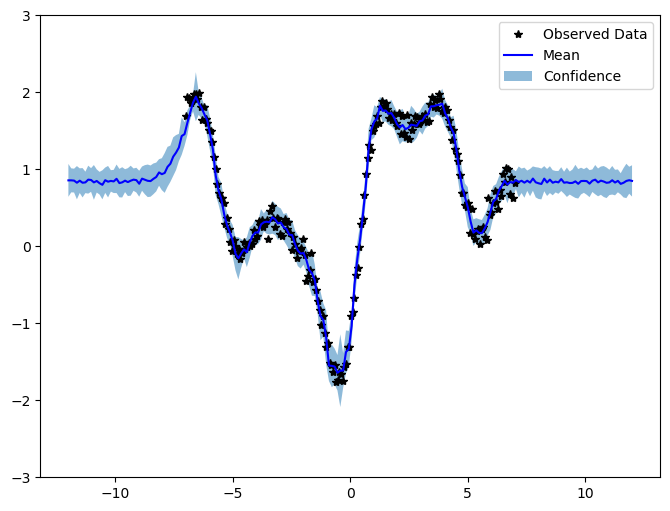

In [206]:
evaluate(dmgp_model)

test loss:  2.1274743


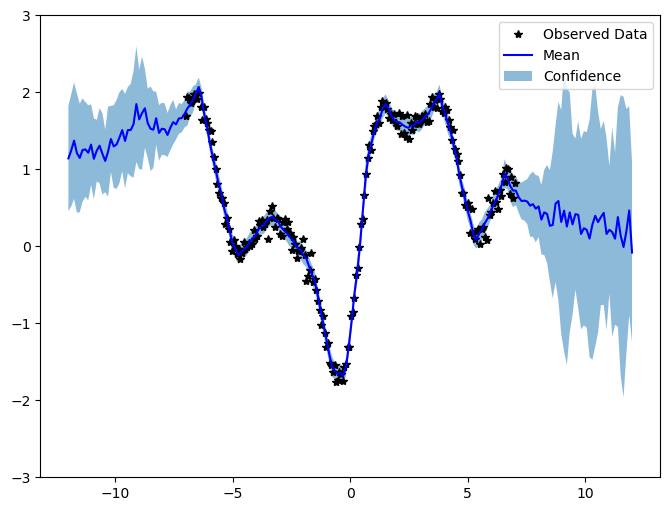

In [207]:
evaluate(dkl_model)

test loss:  8.414948


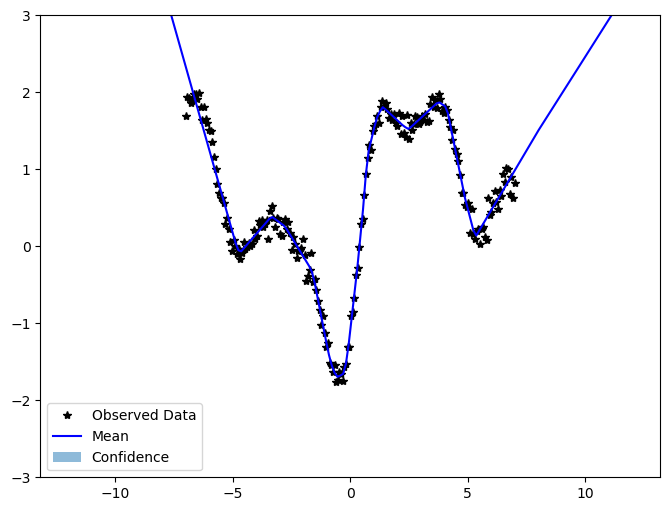

In [208]:
evaluate(dnn_model, bayesian=False)